In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [107]:
# Global parameters
N = 100  # no. data points
N_iters = 1000  # max no. iterations before stopping
noise_std = 0.1
beta_tol = 1e-8  # beta tolerance for stopping iteration when |beta_new - beta_old| <= beta_tol
rng_seed = 2023

# Create data set
rng = np.random.default_rng(rng_seed)
x = rng.random((N, 1))
noise = rng.normal(0, noise_std, x.shape)
y = 5 - 10 * x + 2 * x**2 + noise

# Analytical calculations for comparing
X = np.c_[np.ones((N, 1)), x]  # ??

beta_ols = np.linalg.inv(X.T @ X) @ (X.T @ y)  # own OLS inversion

# Hessian matrices 
H_ols = 2 / N * X.T @ X
eig_ols, _ = np.linalg.eig(H_ols)
print(f"OLS: 1/lambda_max={1 / max(eig_ols):.3f}")

OLS: 1/lambda_max=0.385


# Plain gradient descent (GD) convergence as function of fixed learning rate

### OLS:

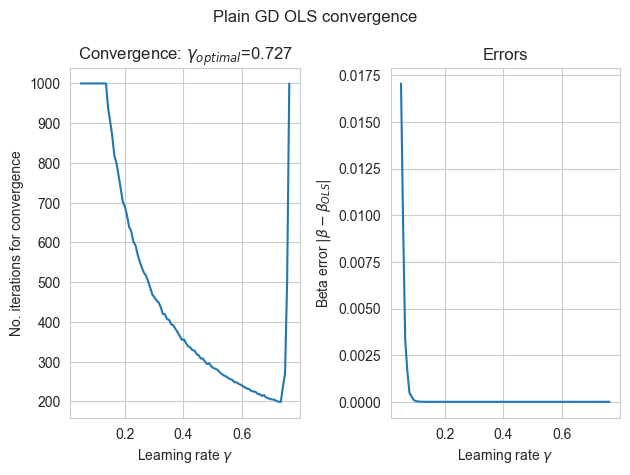

In [113]:
# Parameters
learn_rates = np.linspace(0.05, 2 / np.max(eig_ols), 100, endpoint=False)

no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_prev = beta.copy()

        # Update beta
        grad = 2 / N * X.T @ (X @ beta - y)
        beta -= learn_rate * grad

        iter += 1
    no_iters[i] = iter

    error = max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error

fig, axs = plt.subplots(1, 2)
fig.suptitle(f"Plain GD OLS convergence")

# Plot convergence
axs[0].plot(learn_rates, no_iters)
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learn_rates, errors)
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)

plt.tight_layout()

In [115]:
print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")
print(f"Fastest convergence={np.min(no_iters)}")

Beta OLS=[ 4.5621894  -7.80634126]
Best beta=[ 4.56218941 -7.80634125]
Fastest convergence=199.0


### Ridge:

lmbda=0.001, beta_ridge=[ 4.56144976 -7.80503159], beta=[ 4.48942235 -7.67749763], max error=0.14720665527582355
lmbda=0.01, beta_ridge=[ 4.55480404 -7.79326418], beta=[ 3.92783308 -6.68339652], max error=1.1160303767683146
lmbda=0.1, beta_ridge=[ 4.48942235 -7.67749763], beta=[ 1.78007781 -2.89225475], max error=4.785243487830414
lmbda=1, beta_ridge=[ 3.92783309 -6.68339652], beta=[ 0.3206882  -0.40755246], max error=6.275844135655355
lmbda=10, beta_ridge=[ 1.78007781 -2.89225475], beta=[ 0.04064169 -0.03908504], max error=2.85312266850916


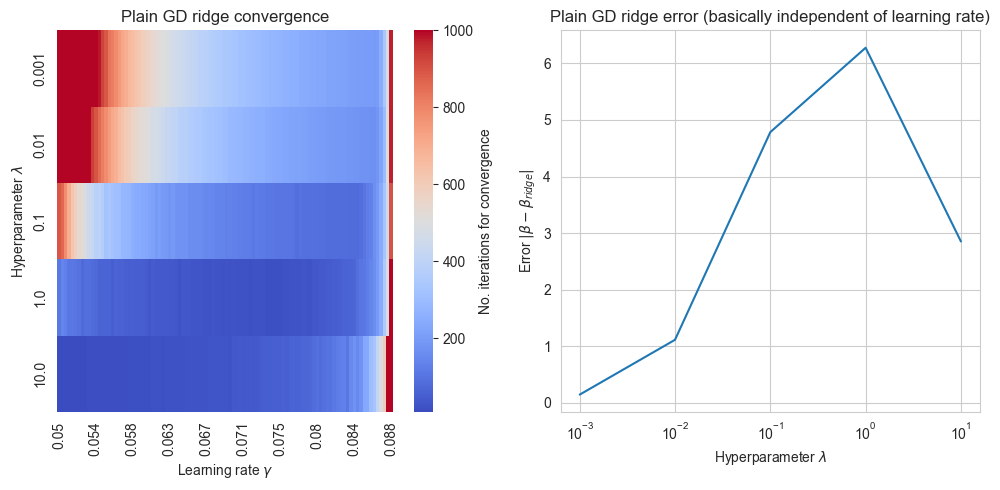

In [116]:
# Parameters
ridge_lambdas = [0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I

    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2 / N * XT_X + 2 * lmbda_I  # Hessian matrix
    eig_ridge, _ = np.linalg.eig(H)

    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2 / np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            beta_prev = beta.copy()

            # Update beta
            grad = 2 / N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            beta -= learn_rate * grad

            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):
                iter = 1000
                break

            iter += 1
        no_iters[i, j] = iter
        errors[i, j] = max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(10, 5))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates) / 10) + 1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks) / 10) + 1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap="coolwarm",
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
)
plt.xticks(rotation=90)  # sideways xticks
ax.collections[0].colorbar.set_label("No. iterations for convergence")
plt.title("Plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Hyperparameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :])  # the errors are the same for each learning rate value
plt.title("Plain GD ridge error (basically independent of learning rate)")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Hyperparameter $\lambda$")
plt.xscale("log")
###### 

plt.tight_layout()

In [117]:
print(f"Min no. iterations={np.min(no_iters)}")
optimal_indices = np.unravel_index(np.argmin(no_iters), no_iters.shape)
print(
        f"Fastest convergence combination (gamma, lambda)=({learn_rates[optimal_indices[0]]:.3f}, {ridge_lambdas[optimal_indices[1]]:.3f}) with error={errors[optimal_indices[0], optimal_indices[1]]:.3f}")

Min no. iterations=9.0
Fastest convergence combination (gamma, lambda)=(0.050, 10.000) with error=2.853


This does not look right to me, 9 iterations is way to low, as we see with the error increasing very much... I'm not sure where my logic fault is atm.

# Gradient descent with momentum/memory (GDM) as function of fixed learning rate

### OLS:

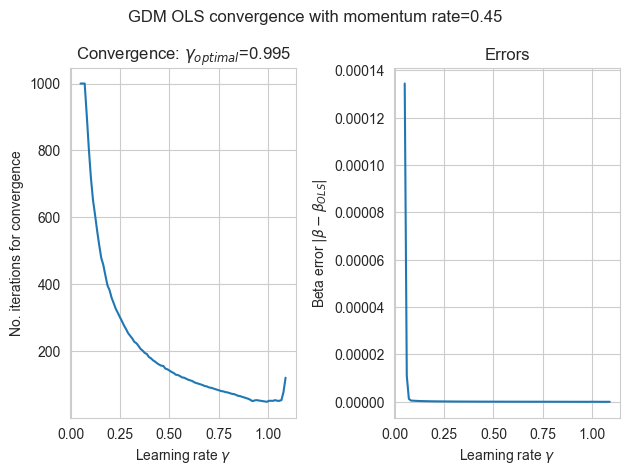

In [173]:
# Parameters
learn_rates = np.linspace(0.05, 1.1, 100, endpoint=False)
momentum_rate = 0.45  # memory rate

no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    change = 0
    iter = 0
    while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
        beta_prev = beta.copy()

        # Calculate new change
        grad = 2 / N * X.T @ (X @ beta - y)
        new_change = learn_rate * grad + momentum_rate * change

        # Update values
        beta -= new_change
        change = new_change.copy()
        iter += 1
    no_iters[i] = iter

    error = max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error

fig, axs = plt.subplots(1, 2)
fig.suptitle(f"GDM OLS convergence with momentum rate={momentum_rate}")

# Plot convergence
axs[0].plot(learn_rates, no_iters)
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learn_rates, errors)
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)

plt.tight_layout()

In [174]:
print(f"Beta OLS={beta_ols.ravel()}")
print(f"Best beta={beta_best.ravel()}")
print(f"Fastest convergence={np.min(no_iters)}")

Beta OLS=[ 4.5621894  -7.80634126]
Best beta=[ 4.56218941 -7.80634125]
Fastest convergence=49.0


### Ridge:

lmbda=0.001, beta_ridge=[ 4.56144976 -7.80503159], beta=[ 4.48942233 -7.6774976 ], max error=0.12762284922286593
lmbda=0.01, beta_ridge=[ 4.55480404 -7.79326418], beta=[ 3.92783308 -6.68339649], max error=1.1098817628104376
lmbda=0.1, beta_ridge=[ 4.48942235 -7.67749763], beta=[ 1.78007781 -2.89225475], max error=4.785243191174262
lmbda=1, beta_ridge=[ 3.92783309 -6.68339652], beta=[ 0.32068819 -0.40755245], max error=6.275844042838319
lmbda=10, beta_ridge=[ 1.78007781 -2.89225475], beta=[ 0.04055825 -0.03913209], max error=2.8531226629338504


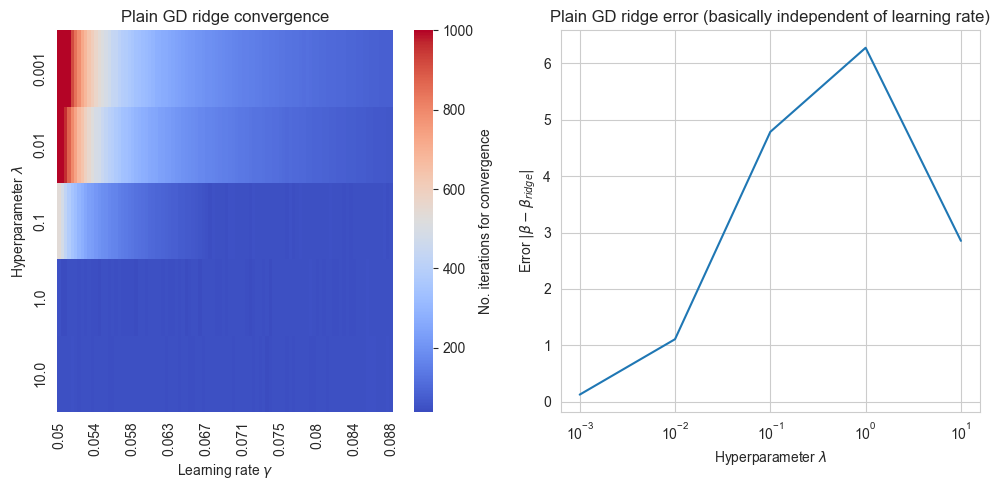

In [158]:
# Parameters
ridge_lambdas = [0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I

    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2 / N * XT_X + 2 * lmbda_I  # Hessian matrix
    eig_ridge, _ = np.linalg.eig(H)

    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2 / np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        change = 0
        iter = 0
        while iter < N_iters and any(abs(beta - beta_prev) > beta_tol):  # convergence test
            beta_prev = beta.copy()

            # Calculate new change
            grad = 2 / N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            new_change = learn_rate * grad + momentum_rate * change

            # Update values
            beta -= new_change
            change = new_change.copy()
            iter += 1

            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):
                iter = 1000
                break

        no_iters[i, j] = iter
        errors[i, j] = max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(10, 5))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates) / 10) + 1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks) / 10) + 1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap="coolwarm",
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
)
plt.xticks(rotation=90)  # sideways xticks
ax.collections[0].colorbar.set_label("No. iterations for convergence")
plt.title("Plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Hyperparameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :])  # the errors are the same for each learning rate value
plt.title("Plain GD ridge error (basically independent of learning rate)")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Hyperparameter $\lambda$")
plt.xscale("log")
###### 

plt.tight_layout()

In [159]:
print(f"Min no. iterations={np.min(no_iters)}")
optimal_indices = np.unravel_index(np.argmin(no_iters), no_iters.shape)
print(
        f"Fastest convergence combination (gamma, lambda)=({learn_rates[optimal_indices[0]]:.3f}, {ridge_lambdas[optimal_indices[1]]:.3f}) with error={errors[optimal_indices[0], optimal_indices[1]]:.3f}")

Min no. iterations=38.0
Fastest convergence combination (gamma, lambda)=(0.074, 1.000) with error=6.276


Again I'm not sure this is correct.

# Stochastic gradient descent (SDG) as function of batch size $M$ and number of epochs $N_\text{epochs}$, with replacement

### OLS:

In [243]:
# SDG parameters
m_vals = [1, 10, 100]  # number of minibatches
N_epoch_vals = [1, 10, 100, 1000]  # number of iterations over all the minibatches 
M_vals = (N / np.asarray(m_vals)).astype(int)

# Learning rate config
t0 = 5
t1 = 50


def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time/iterations."""
    return t0 / (t + t1)


print(f"beta_ols={beta_ols.ravel()}")
for N_epoch in N_epoch_vals:  # iterate through different epochs values
    for k, m in enumerate(m_vals):  # then iterate through different values of total number of batches
        M = M_vals[k]  # size of each minibatch
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1]

        for epoch in range(N_epoch):  # then iterate through all different epoch values
            for i in range(m):  # now do the ols calculation for the epoch iterations
                random_index = M * rng.integers(m)
                xi = X[random_index:random_index + M]
                yi = y[random_index:random_index + M]
                gradients = 2 / M * xi.T @ ((xi @ beta) - yi)
                learn_rate = learning_schedule(epoch * m + i)
                beta -= learn_rate * gradients
        print(f"beta={beta.ravel()}")

beta_ols=[ 4.5621894  -7.80634126]
beta=[0.33692239 0.7916856 ]
beta=[ 0.26367116 -0.51387051]
beta=[ 2.40173369 -4.12552805]
beta=[ 1.05133404 -1.40138304]
beta=[ 2.26382312 -3.90879915]
beta=[ 3.82927127 -6.51285952]
beta=[ 2.31980073 -3.82913121]
beta=[ 3.86647311 -6.55753309]
beta=[ 4.40503332 -7.52350141]
beta=[ 3.88756995 -6.60980334]
beta=[ 4.39214618 -7.50416227]
beta=[ 4.51417008 -7.72216746]
